# Age-sex joint distributions from E_Detect-TB data 

Data from the [E-DETECT TB consortium](https://e-detecttb.eu/) records numbers of TB screenings for people entering the UK, stratified by year, country, age group, sex and visa category. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

encPath = '..\\SharedFiles\\'


# FUNCTIONS...
# Takes a sub-dataframe, extracts the age/sex categories and normalises to one.
def getNormedAgeSexDistr2(test_df):
    ID_grouped = test_df.groupby('Name')
    ID_sum = ID_grouped['n_screened'].agg(np.sum)

    b_dict = {x: i for i, x in enumerate(ID_sum.index)}
    indices = [b_dict.get(x, None) for x in names]

    qq = np.array([ID_sum.values[i] if i is not None else 0 for i in indices])
    return qq/(np.sum(qq)+0.001)


# Takes a sub-dataframe, extracts the age/sex categories and but DOESN'T normalise to one.
def getNormedAgeSexDistrN(test_df):
    ID_grouped = test_df.groupby('Name')
    ID_sum = ID_grouped['n_screened'].agg(np.sum)

    b_dict = {x: i for i, x in enumerate(ID_sum.index)}
    indices = [b_dict.get(x, None) for x in names]

    qq = np.array([ID_sum.values[i] if i is not None else 0 for i in indices])
    return qq


# Read in the data...
# The data is a cleaned version of clean_edetecttb_11oct_withregion.csv that was prepared by Laura. 
fileName = 'clean_edetecttb_JET.csv'

E_DET_TB_data = pd.read_csv(fileName, comment='#')
E_DET_TB_data['sex'] = E_DET_TB_data['sex'].astype(str)

colNames = E_DET_TB_data.columns.values

# re-order the columns to put the counts at the end. 
newColOrder = [colNames[x] for x in [0, 1, 2, 4, 5, 6, 3]]
E_DET_TB_data = E_DET_TB_data[newColOrder]

# Drop the country column. 
E_DET_TB_data.drop('country', axis='columns', inplace=True)

# Which Encoding are we using? 
allEncodings = ['4visa', '3visa', '3v6c']
Encoding = allEncodings[0]

# Get the right coding definitions. 
encodingFileName = encPath + f'DefEncoding_{Encoding}.p'
pickle_input = open(encodingFileName, 'rb')
country2Index_dict, sexes, defVisaCats, Visa2Index_dict, visaSet, \
    EDetTB2VisaCats, regionSet = pickle.load(pickle_input)


# Clean data...
# Remove 'Missing' in 'sex'. 'age_grps', 'year'
sexMissingFilter = E_DET_TB_data['sex'].isin(['Missing'])
ageGroupMissingFilter = E_DET_TB_data['age_grps'].isin(['Missing'])
yearMissingFilter = E_DET_TB_data['year'].isin(['Missing'])
visaMissingFilter = E_DET_TB_data['visa_type'].isin(['Missing'])
totalFilter = sexMissingFilter.values | ageGroupMissingFilter.values \
    | yearMissingFilter.values | visaMissingFilter.values

# totalFilter = totalFilter == False  # Seriously, this is how to 'not'?
totalFilter = [not x for x in totalFilter]

E_DET_TB_Filtered_data = E_DET_TB_data[totalFilter]

allAgeGroups = np.unique(E_DET_TB_Filtered_data['age_grps'])
# re-order...
reOrder = [0, 10, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 
           15, 16, 17, 18, 19, 20, 2]
allAgeGroups = [allAgeGroups[x] for x in reOrder]

colNames = list(E_DET_TB_Filtered_data.columns.values)

# Aggregate if necessary...
# if Encoding == '3visa':
#    # replace 'UK Family Reunification' and 'UK Settlement' with 'UK Family' 
#    oldValues = ['UK Family Reunification', 'UK Settlement']
#    newValue = 'UK Family'
#    E_DET_TB_Filtered_data2 = E_DET_TB_Filtered_data.replace(to_replace=oldValues, 
#                                                             value=newValue)
#    grouped = E_DET_TB_Filtered_data2.groupby(colNames[:-1])
#    gTotals = grouped['n_screened'].agg(np.sum)
#
#    test = [list(i) + [v] for i, v in gTotals.iteritems()]
#    newData = pd.DataFrame(test)
#    newData.columns = colNames
#    E_DET_TB_Filtered_data = newData

Below is a summary of the colmns in the data and the range of values each contains. 

In [2]:
nRows = E_DET_TB_Filtered_data.shape[0]
print('Rows: ', nRows)

colNames = E_DET_TB_Filtered_data.columns.values

# Print out all the unique values in each column...
for n, v in E_DET_TB_Filtered_data[colNames[:-1]].iteritems():
    print(n, np.unique(v))

Rows:  41526
sex ['Female' 'Male']
age_grps ['0-4' '10-14' '100+' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44'
 '45-49' '5-9' '50-54' '55-59' '60-64' '65-69' '70-74' '75-79' '80-84'
 '85-89' '90-94' '95-99']
year ['2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018']
visa_type ['UK Family Reunification' 'UK Settlement' 'UK Student' 'UK VISA (other)'
 'UK Work' 'UK Working Holiday']
region ['Bangladesh' 'Caribbean' 'China' 'Europe' 'India' 'N_Africa' 'Other_Asia'
 'Pakistan' 'SE_Asia' 'S_America' 'Sub_Saharan_Africa']


We further fiter the data according to the regions of origin that are of interest and also the main visa categories. These are both listed below: 

In [3]:
# desired visa types and regions.
# visa cats were read in from the encoding pickle. 
# visaSet = ['UK Settlement', 'UK Family Reunification', 'UK Student', 'UK Work']
regions = ['China', 'Bangladesh', 'India', 'Pakistan']

print('Visa categories considered:')
print(visaSet)
print('\nRegions considered:')
print(regions)

# Data before 2015 is dodgy, so filter it out. 
filterYears = E_DET_TB_Filtered_data['year'].values.astype(int) >= 2015

# Just the following regions...
filterCountries = E_DET_TB_Filtered_data['region'].isin(regions).values

# filter the desired visas.
filterVisas = E_DET_TB_Filtered_data['visa_type'].isin(visaSet).values

# copy to avoid problems. 
E_DET_TB_Filtered_data2 = E_DET_TB_Filtered_data[filterYears &
                                                filterCountries & filterVisas].copy()

nRows = E_DET_TB_Filtered_data2.shape[0]

# Create the categories of age and sex groupings, in order.
# 20 5 year groups and two sexes.
# sexes defn read in with the pickled encodings. 
# sexes = ['M', 'F']
N = 20
names = [sexes[i//N] + ':' + str(i % N*5) + '-' + str(i % N*5+4) \
         for i in range(2*N)]

years = np.unique(E_DET_TB_Filtered_data2['year'])

# Create some ids for the categories of sex and age. 
aa = list(E_DET_TB_Filtered_data2['sex'].values)
bb = list(E_DET_TB_Filtered_data2['age_grps'].values)
E_DET_TB_Filtered_data2['Name'] = [aa[i][0] + ':' + bb[i] for i in range(nRows)]


# Group by country and visa. 
grouped = E_DET_TB_Filtered_data2.groupby(['region', 'visa_type'])
# Apply normalisation function to groups. 
MeanAgeSexDistrByCV = grouped.apply(getNormedAgeSexDistr2)

# Check normalisation... 
# test = [np.sum(x) for x in MeanAgeSexDistrByCV]

# group by region, visa_type and year.
grouped2 = E_DET_TB_Filtered_data2.groupby(['region', 'visa_type', 'year'])

meanByCVYear = grouped2.apply(getNormedAgeSexDistr2)

Visa categories considered:
['UK Settlement', 'UK Family Reunification', 'UK Student', 'UK Work']

Regions considered:
['China', 'Bangladesh', 'India', 'Pakistan']


Our assumption is that the age and sex distribution of immigrants is a function of the country of origin and the visa type, but independent of the year of entry and the number of immigrants. As such, we construct a joint age/sex distribution for imigrants by averaging over a number of entry years. Currently, only entry years of 2015 and later are used, as prior to this, the data is not reliable. For a given country of origin and visa type, if $n_{ij}$ is the number of individuals screened in age/sex category $i$ and entry year $j$, then probability for age/sex category $i$ is 
$$ 
p_i \propto \sum_j n_{ij},
$$
normalised to 1. Hence entry years with fewer screenings contribute less. 

The following panels show the mean age/sex distributions by country and visa category, along with the distributions for the years from which they are constituted. This gives an idea of how strong the assumption of time-independence is. 

### Normalised distributions

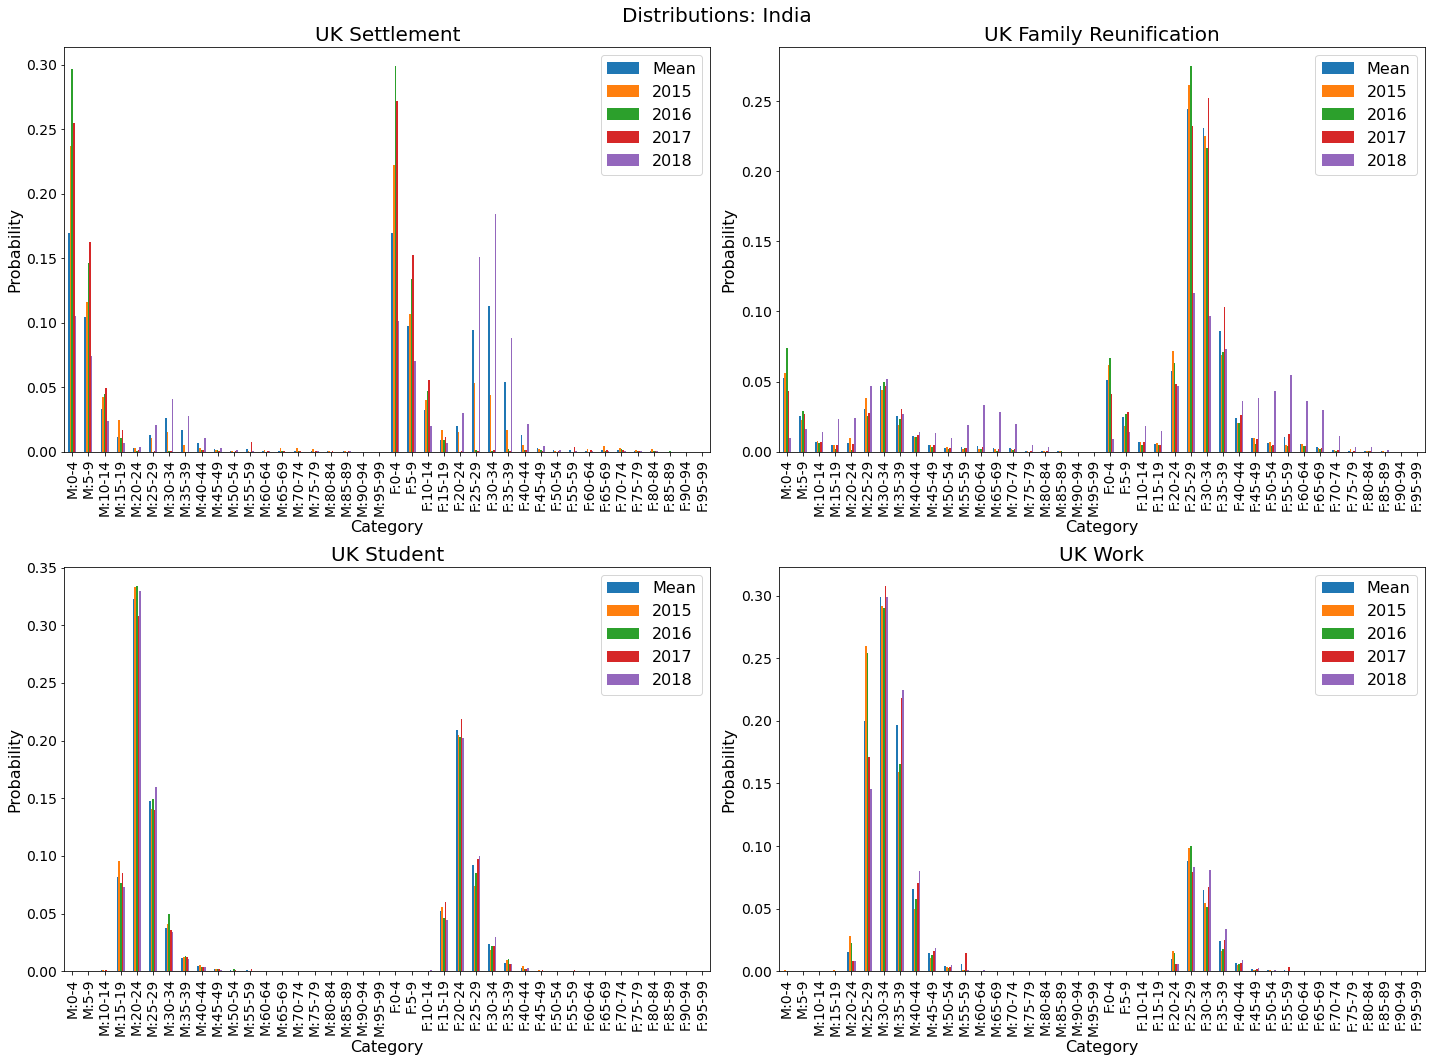

In [4]:
currentRegion = 'India'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

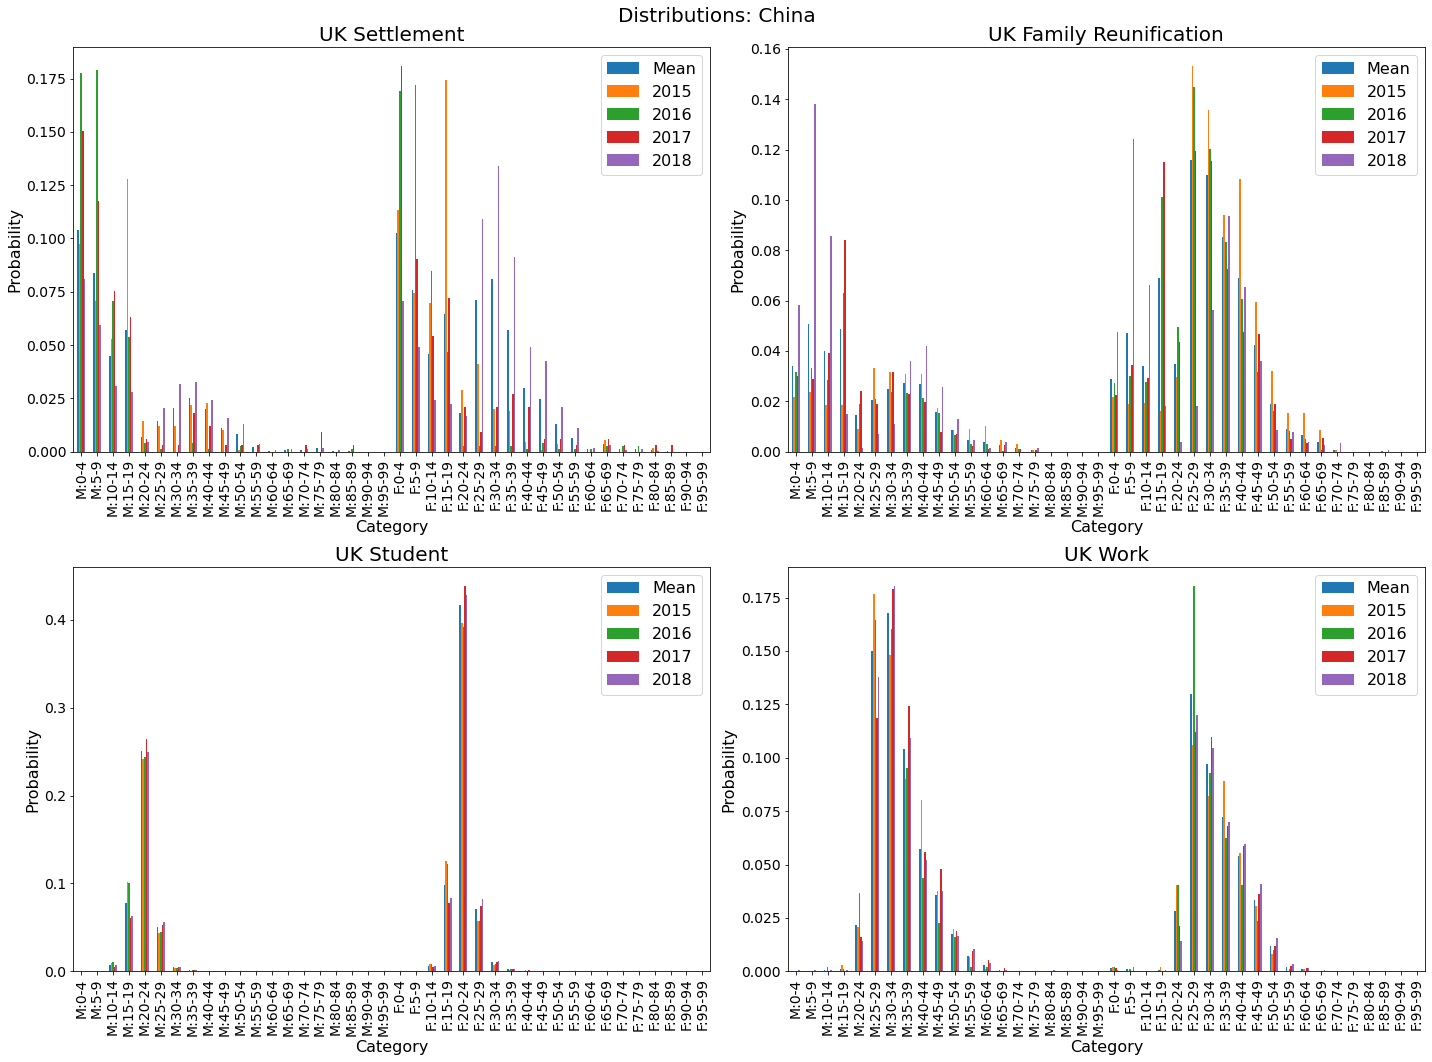

In [5]:
currentRegion = 'China'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

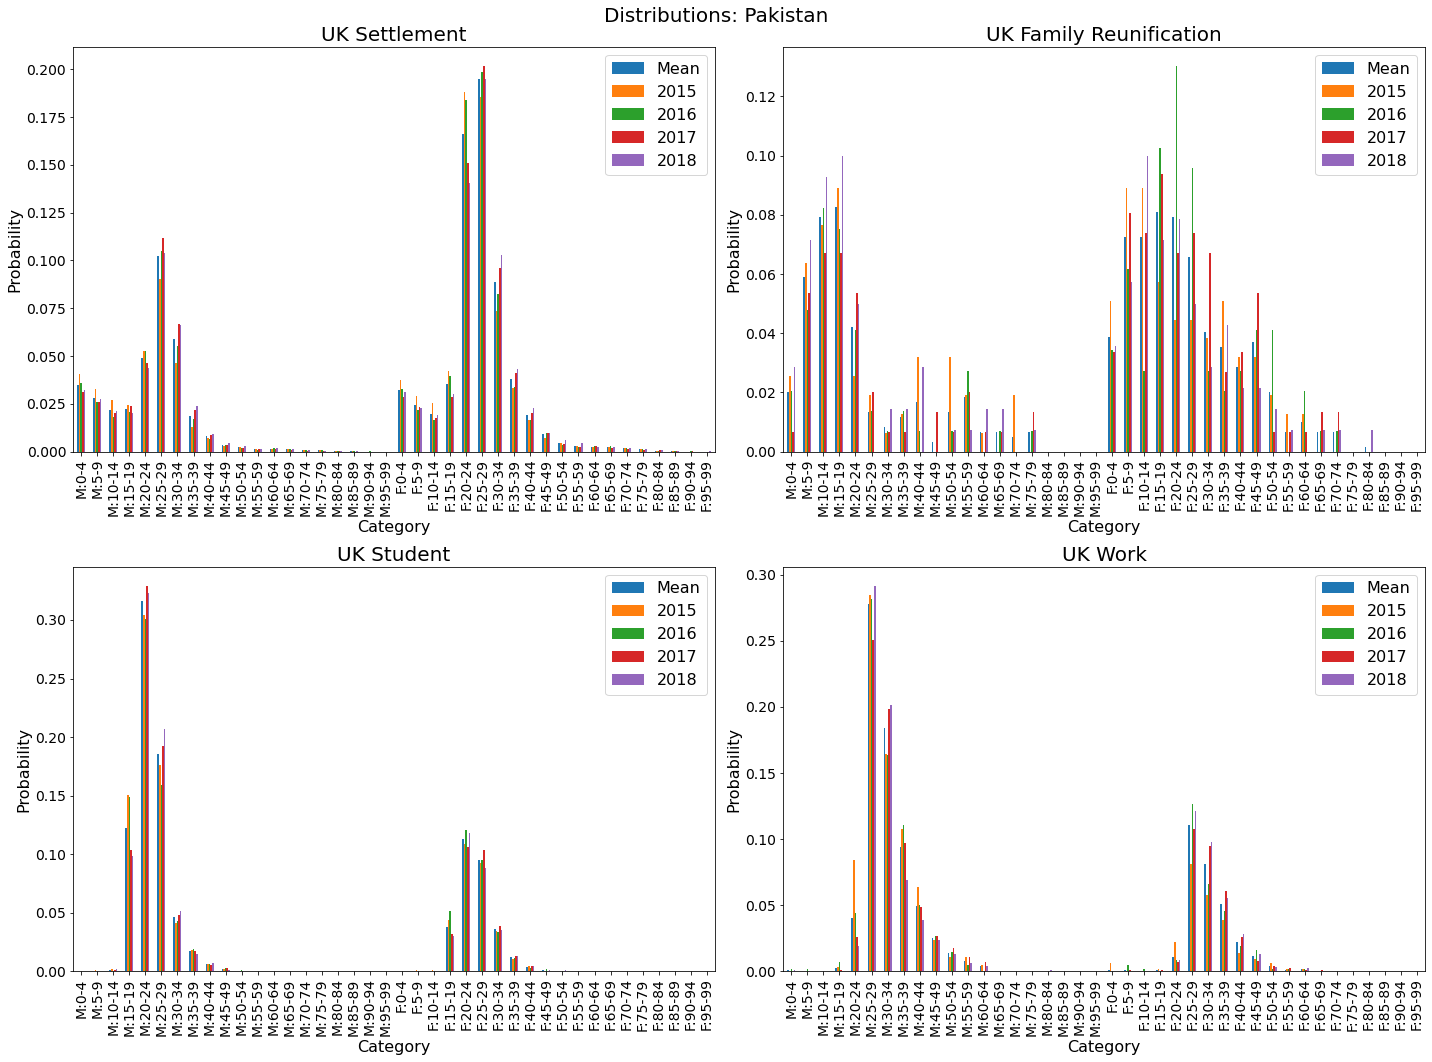

In [6]:
currentRegion = 'Pakistan'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

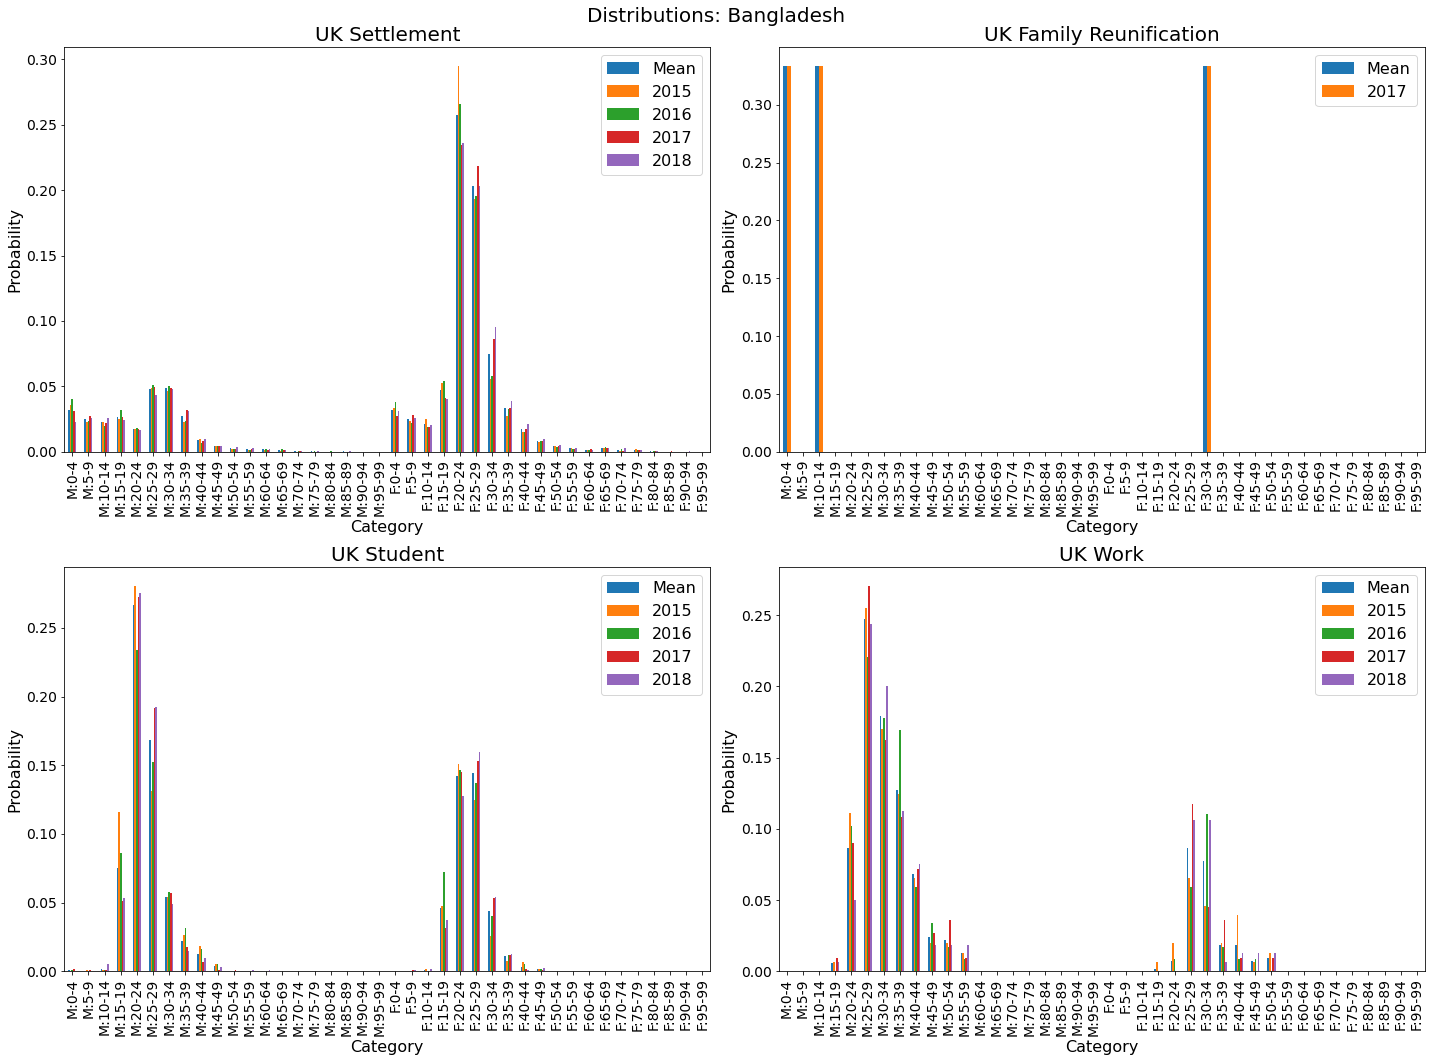

In [7]:
currentRegion = 'Bangladesh'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(4):
    # if i == 1:
    #    continue
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        if not np.any(meanByCVYear.index.isin([currentIndex])):
            continue
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

***
### Distribution of numbers screened
Visualising in terms of the numbers screened may throw some light on the changes in the distributions wiht time.  

In [8]:
# apply the total number function to the grouping. 
totalByCVYear = grouped2.apply(getNormedAgeSexDistrN)

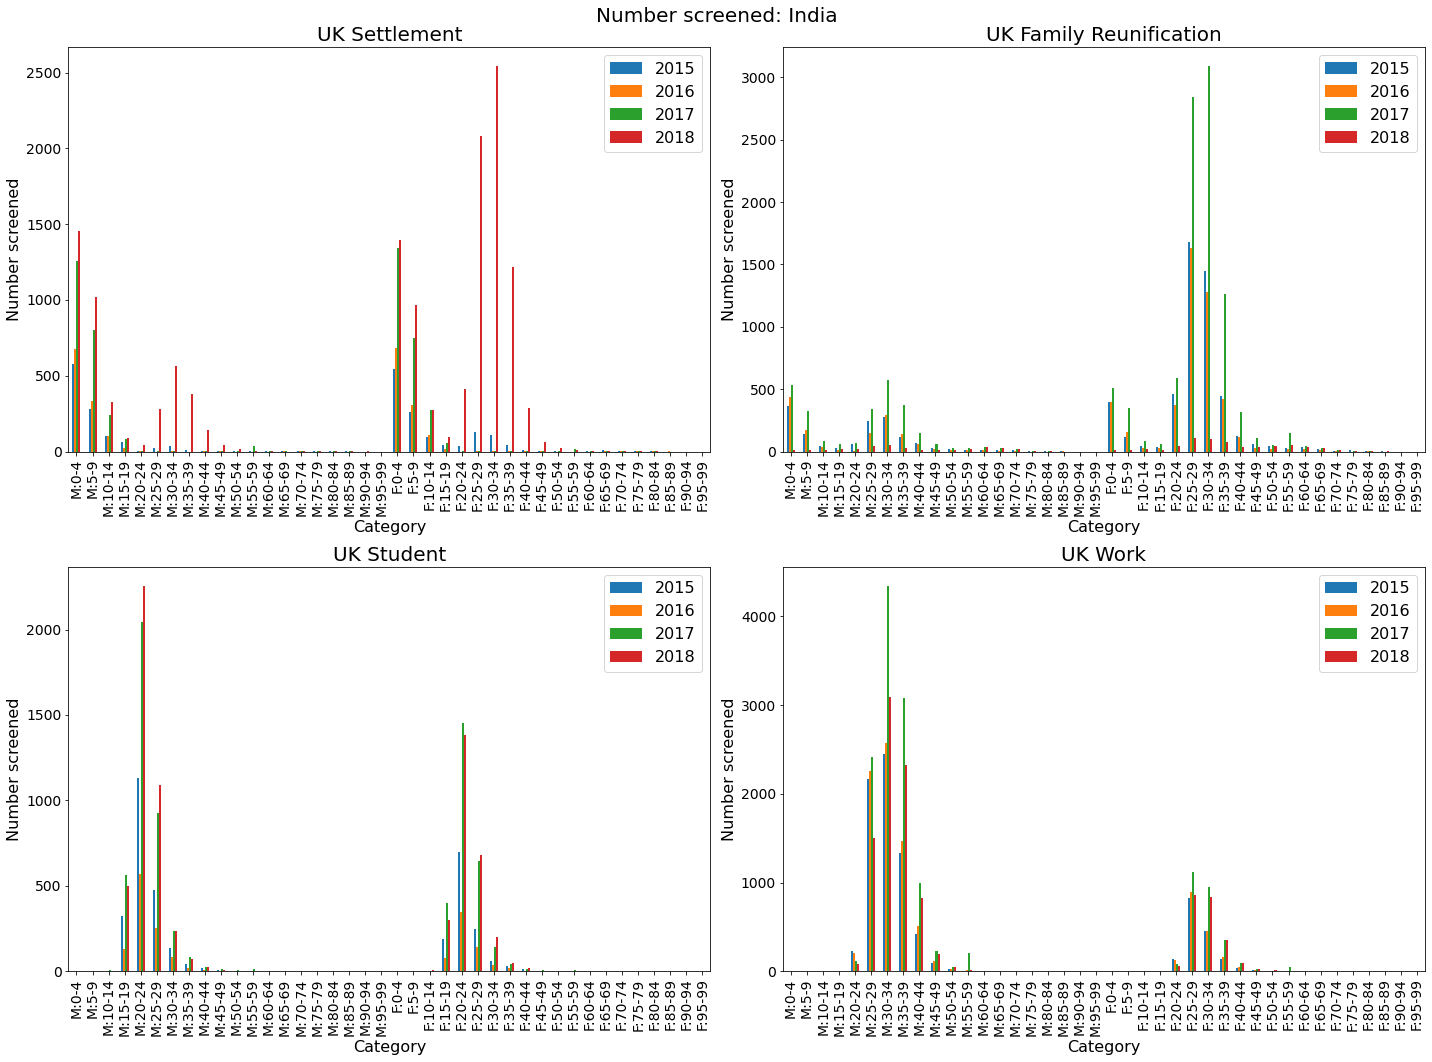

In [9]:
currentRegion = 'India'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = totalByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', y=years, rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Number screened', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Number screened: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

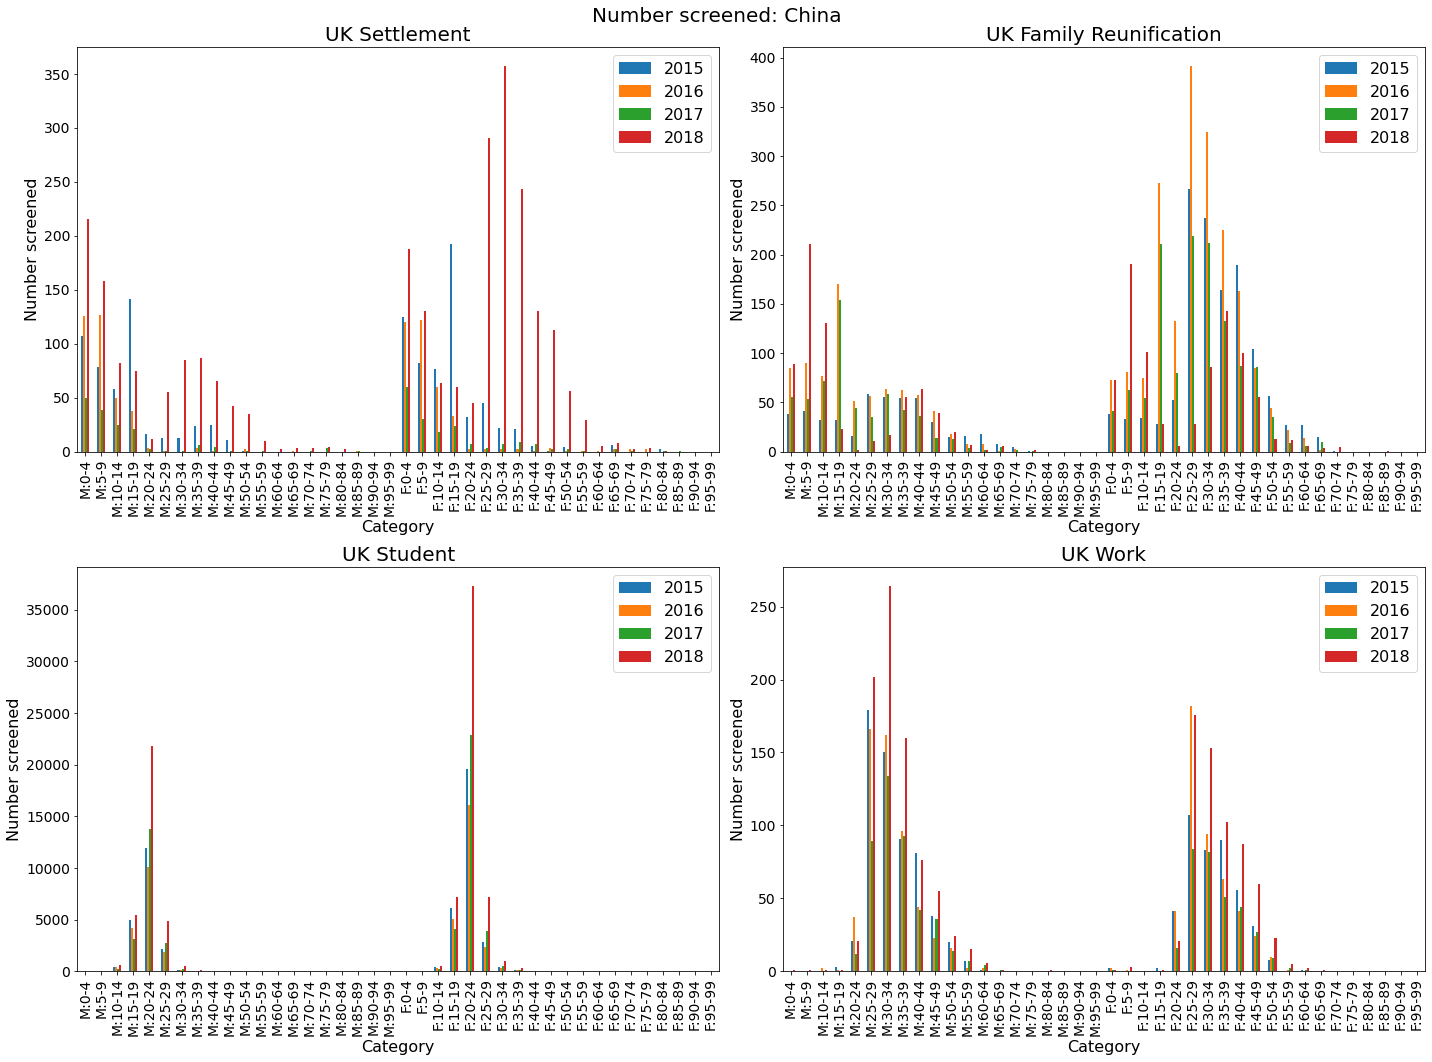

In [10]:
currentRegion = 'China'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = totalByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', y=years, rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Number screened', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Number screened: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

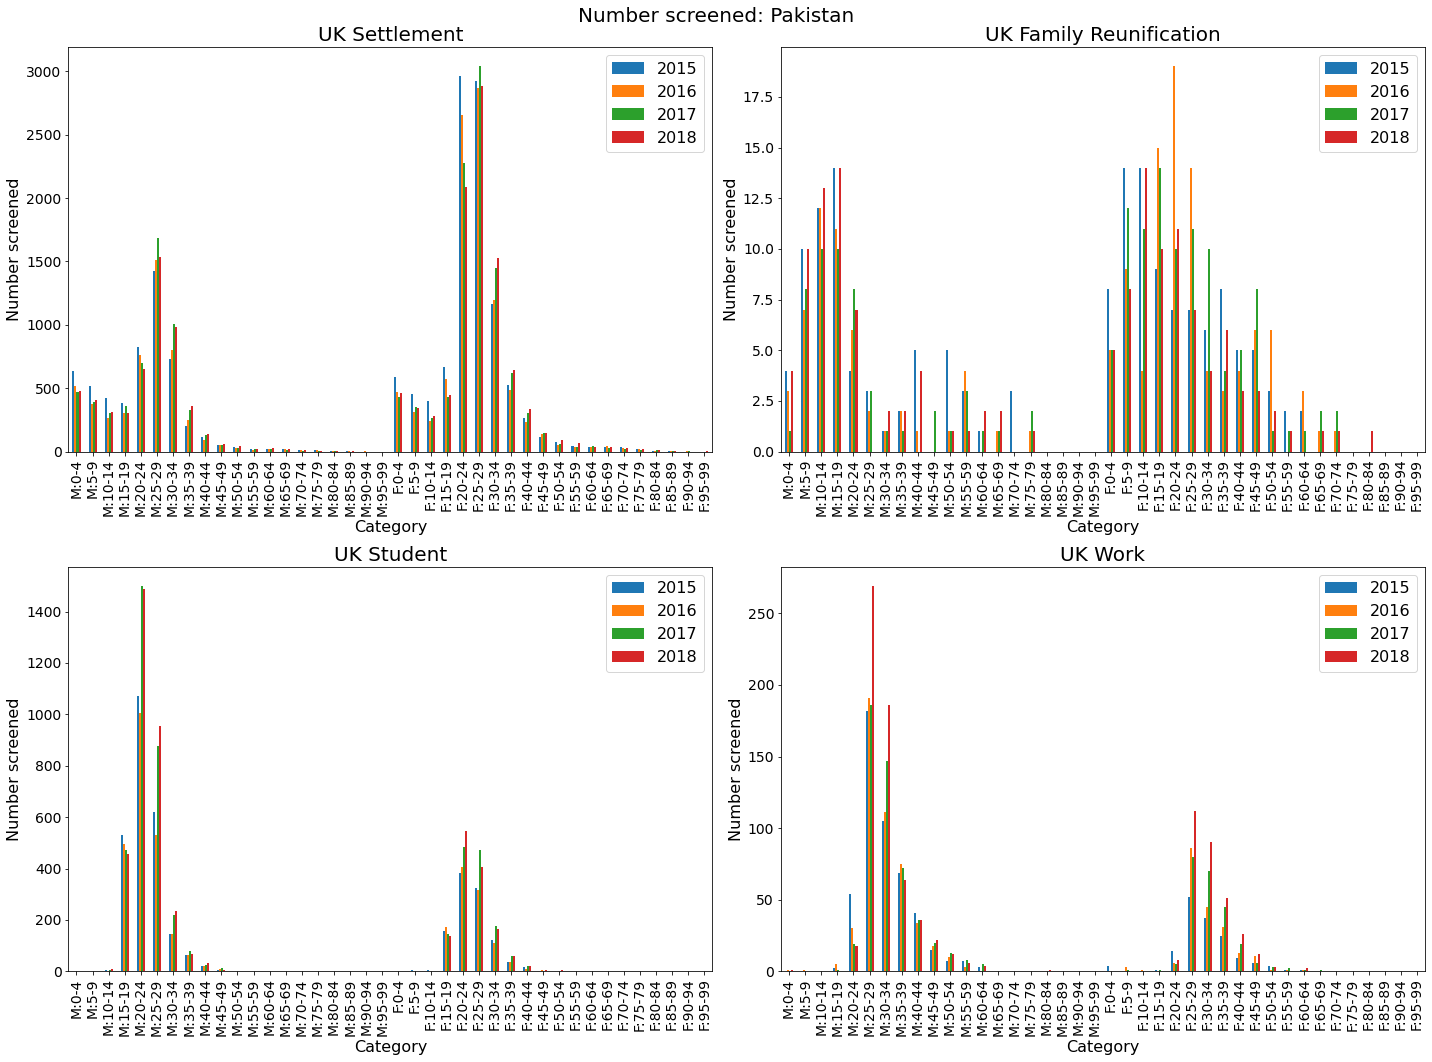

In [11]:
currentRegion = 'Pakistan'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = totalByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', y=years, rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Number screened', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Number screened: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

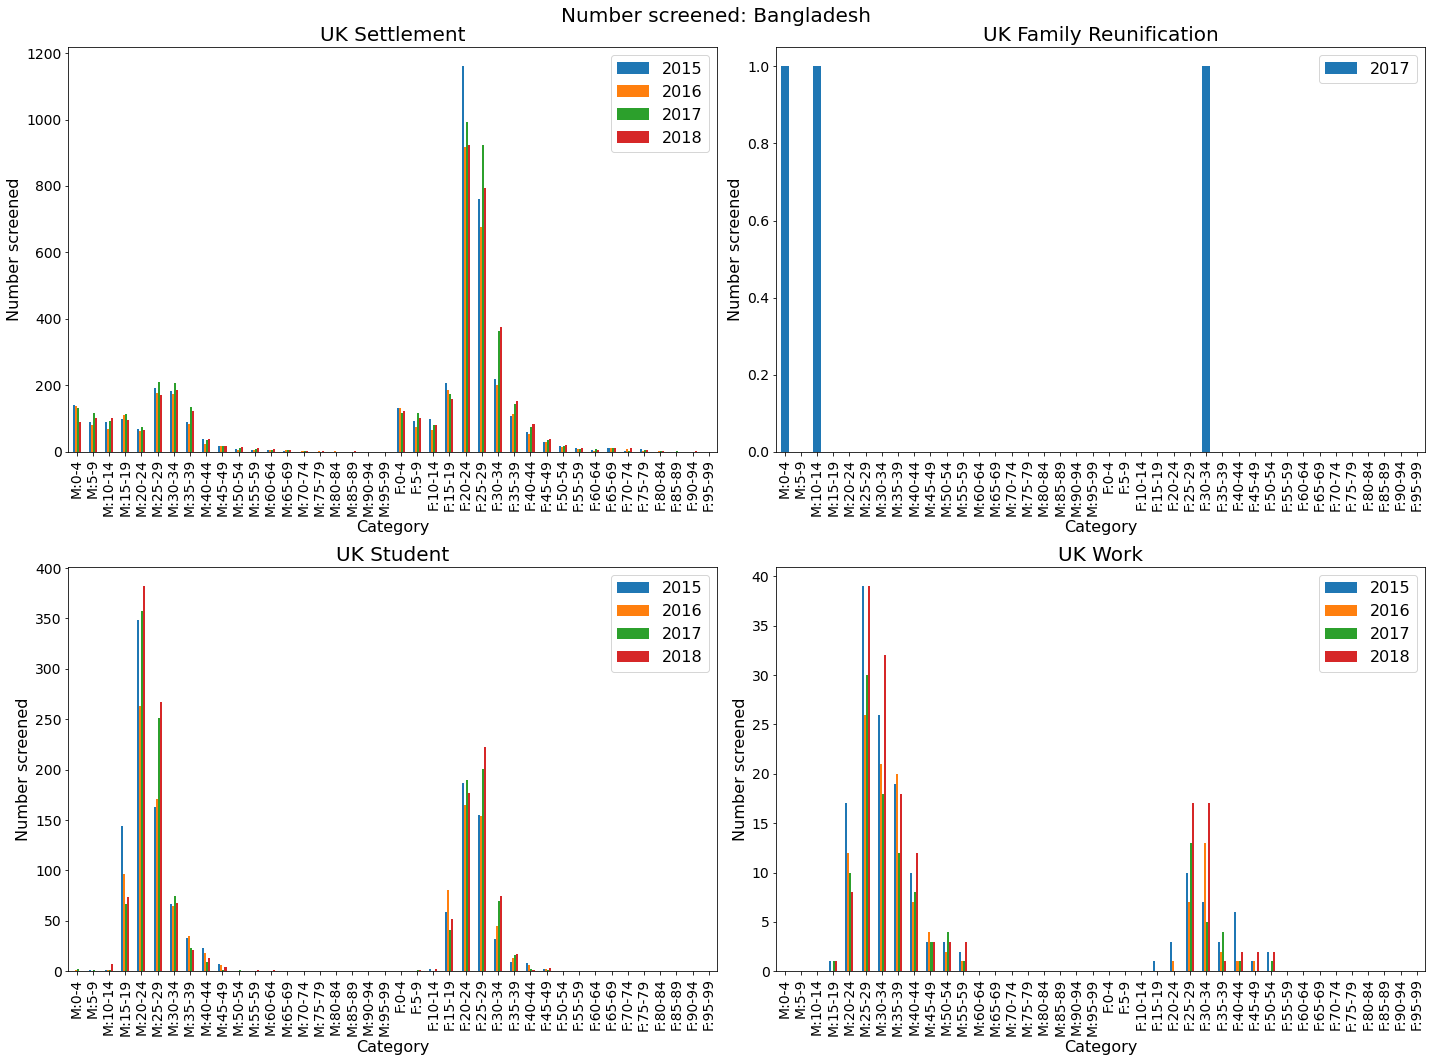

In [12]:
currentRegion = 'Bangladesh'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(n_cols*n_rows):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    outputYears = []
    for y in years:
        currentIndex = CV + (y,)
        if not np.any(totalByCVYear.index.isin([currentIndex])):
            continue

        plot_df[y] = totalByCVYear[currentIndex]
        outputYears = outputYears + [y]

    plot_df.plot.bar(x='Labels', y=outputYears, rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Number screened', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Number screened: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

## 3-visa + Sub-Saharan Africa encoding: **3v6c**
Due to the apparent flow between the family visa classes **UK Settlement** and **UK Family Reunification** over time, we combine them into a single visa class, **UK Family**. Also, we've included the region of Sub-Saharan Africa. 

In [13]:
# This gives the 3visa encoding.
Encoding = allEncodings[2]

# Get the right coding definitions.
encodingFileName = encPath + f'DefEncoding_{Encoding}.p'
pickle_input = open(encodingFileName, 'rb')
country2Index_dict, sexes, defVisaCats, Visa2Index_dict, visaSet, \
    EDetTB2VisaCats, regionSet = pickle.load(pickle_input)

# replace 'UK Family Reunification' and 'UK Settlement' with 'UK Family'
oldValues = ['UK Family Reunification', 'UK Settlement']
newValue = 'UK Family'
E_DET_TB_Filtered_data2 = E_DET_TB_Filtered_data.replace(to_replace=oldValues,
                                                         value=newValue)

colNames = list(E_DET_TB_Filtered_data2.columns.values)
grouped = E_DET_TB_Filtered_data2.groupby(colNames[:-1])
gTotals = grouped['n_screened'].agg(np.sum)

test = [list(i) + [v] for i, v in gTotals.iteritems()]
newData = pd.DataFrame(test)
newData.columns = colNames
E_DET_TB_Filtered_data = newData

In [14]:
nRows = E_DET_TB_Filtered_data.shape[0]
print('Rows: ', nRows)

colNames = E_DET_TB_Filtered_data.columns.values

# Print out all the unique values in each column...
for n, v in E_DET_TB_Filtered_data[colNames[:-1]].iteritems():
    print(n, np.unique(v))

Rows:  11650
sex ['Female' 'Male']
age_grps ['0-4' '10-14' '100+' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44'
 '45-49' '5-9' '50-54' '55-59' '60-64' '65-69' '70-74' '75-79' '80-84'
 '85-89' '90-94' '95-99']
year ['2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018']
visa_type ['UK Family' 'UK Student' 'UK VISA (other)' 'UK Work' 'UK Working Holiday']
region ['Bangladesh' 'Caribbean' 'China' 'Europe' 'India' 'N_Africa' 'Other_Asia'
 'Pakistan' 'SE_Asia' 'S_America' 'Sub_Saharan_Africa']


In [15]:
# desired visa types and regions.
# visa cats and regions/countries were read in from the encoding pickle. 
# visaSet = ['UK Settlement', 'UK Family Reunification', 'UK Student', 'UK Work']
# regions = ['China', 'Bangladesh', 'India', 'Pakistan']

print('Visa categories considered:')
print(visaSet)
print('\nRegions considered:')
print(regionSet)

# Data before 2015 is dodgy, so filter it out.
filterYears = E_DET_TB_Filtered_data['year'].values.astype(int) >= 2015

# Just the following regions...
filterCountries = E_DET_TB_Filtered_data['region'].isin(regionSet).values

# filter the desired visas.
filterVisas = E_DET_TB_Filtered_data['visa_type'].isin(visaSet).values

# copy to avoid problems. 
E_DET_TB_Filtered_data2 = E_DET_TB_Filtered_data[filterYears &
                                                 filterCountries & filterVisas].copy()

nRows = E_DET_TB_Filtered_data2.shape[0]

# Create the categories of age and sex groupings, in order.
# 20 5 year groups and two sexes.
# sexes defn read in with the pickled encodings. 
# sexes = ['M', 'F']
N = 20
names = [sexes[i//N] + ':' + str(i % N*5) + '-' + str(i % N*5+4) \
         for i in range(2*N)]

years = np.unique(E_DET_TB_Filtered_data2['year'])

# Create some ids for the categories of sex and age. 
aa = list(E_DET_TB_Filtered_data2['sex'].values)
bb = list(E_DET_TB_Filtered_data2['age_grps'].values)
E_DET_TB_Filtered_data2['Name'] = [aa[i][0] + ':' + bb[i] for i in range(nRows)]


# Group by country and visa. 
grouped = E_DET_TB_Filtered_data2.groupby(['region', 'visa_type'])
# Apply normalisation function to groups. 
MeanAgeSexDistrByCV = grouped.apply(getNormedAgeSexDistr2)

# Check normalisation... 
# test = [np.sum(x) for x in MeanAgeSexDistrByCV]

# group by region, visa_type and year.
grouped2 = E_DET_TB_Filtered_data2.groupby(['region', 'visa_type', 'year'])

meanByCVYear = grouped2.apply(getNormedAgeSexDistr2)

Visa categories considered:
['UK Family', 'UK Student', 'UK Work']

Regions considered:
['China', 'Bangladesh', 'India', 'Pakistan', 'Sub_Saharan_Africa']


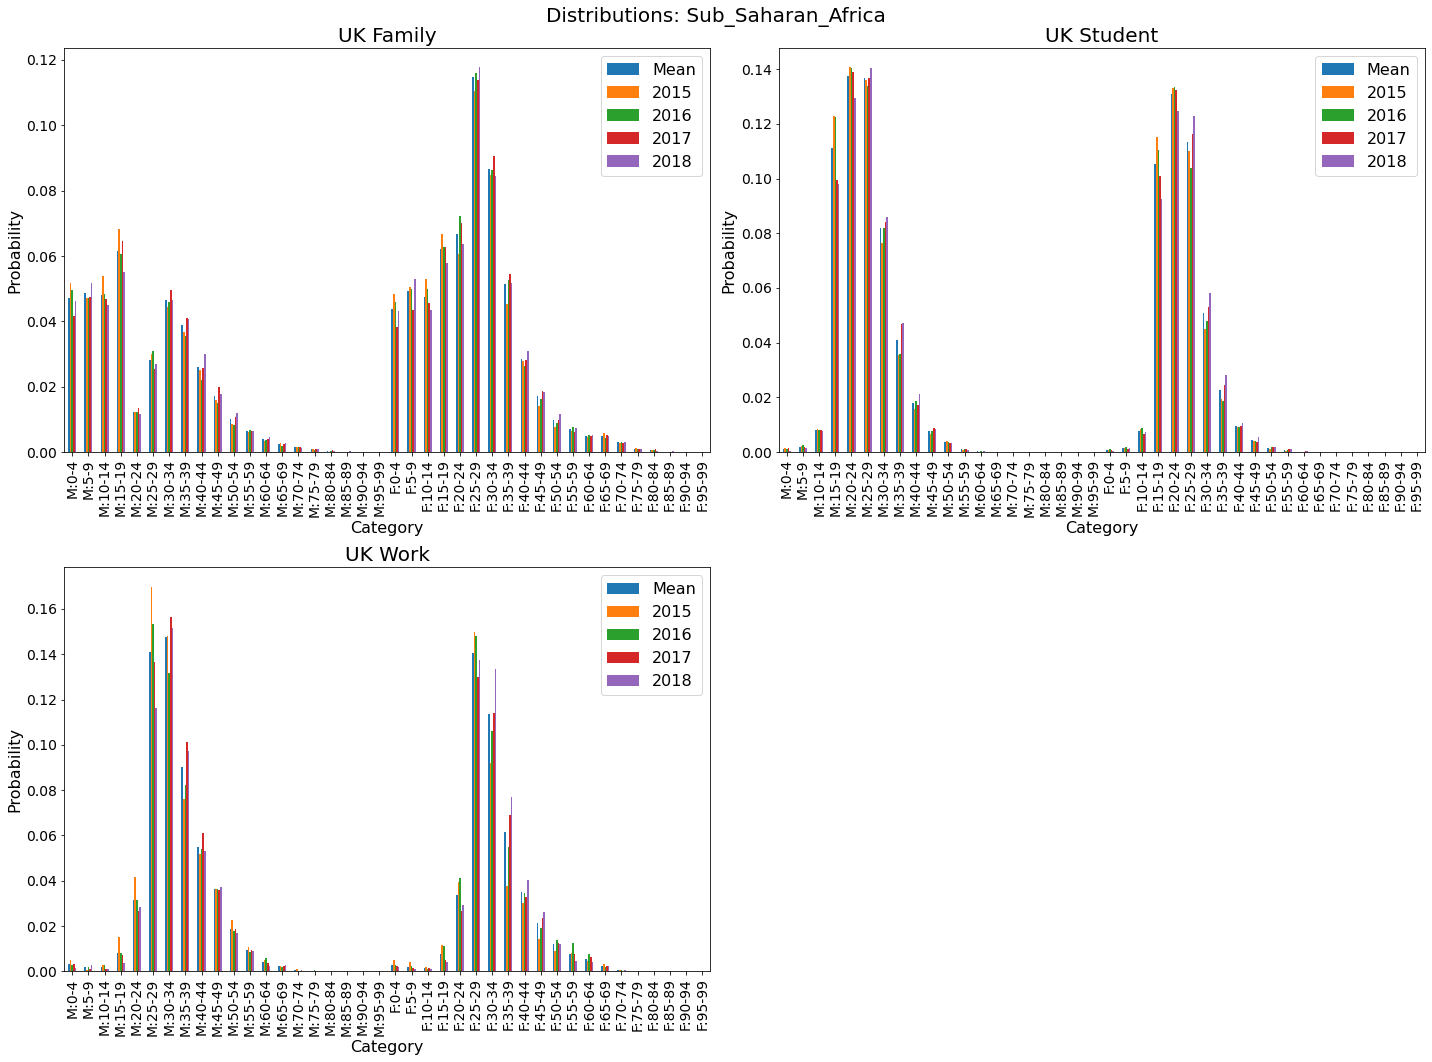

In [16]:
currentRegion = 'Sub_Saharan_Africa'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(3):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)

# Turn off the last subplot. 
ax[-1, -1].axis('off')

fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

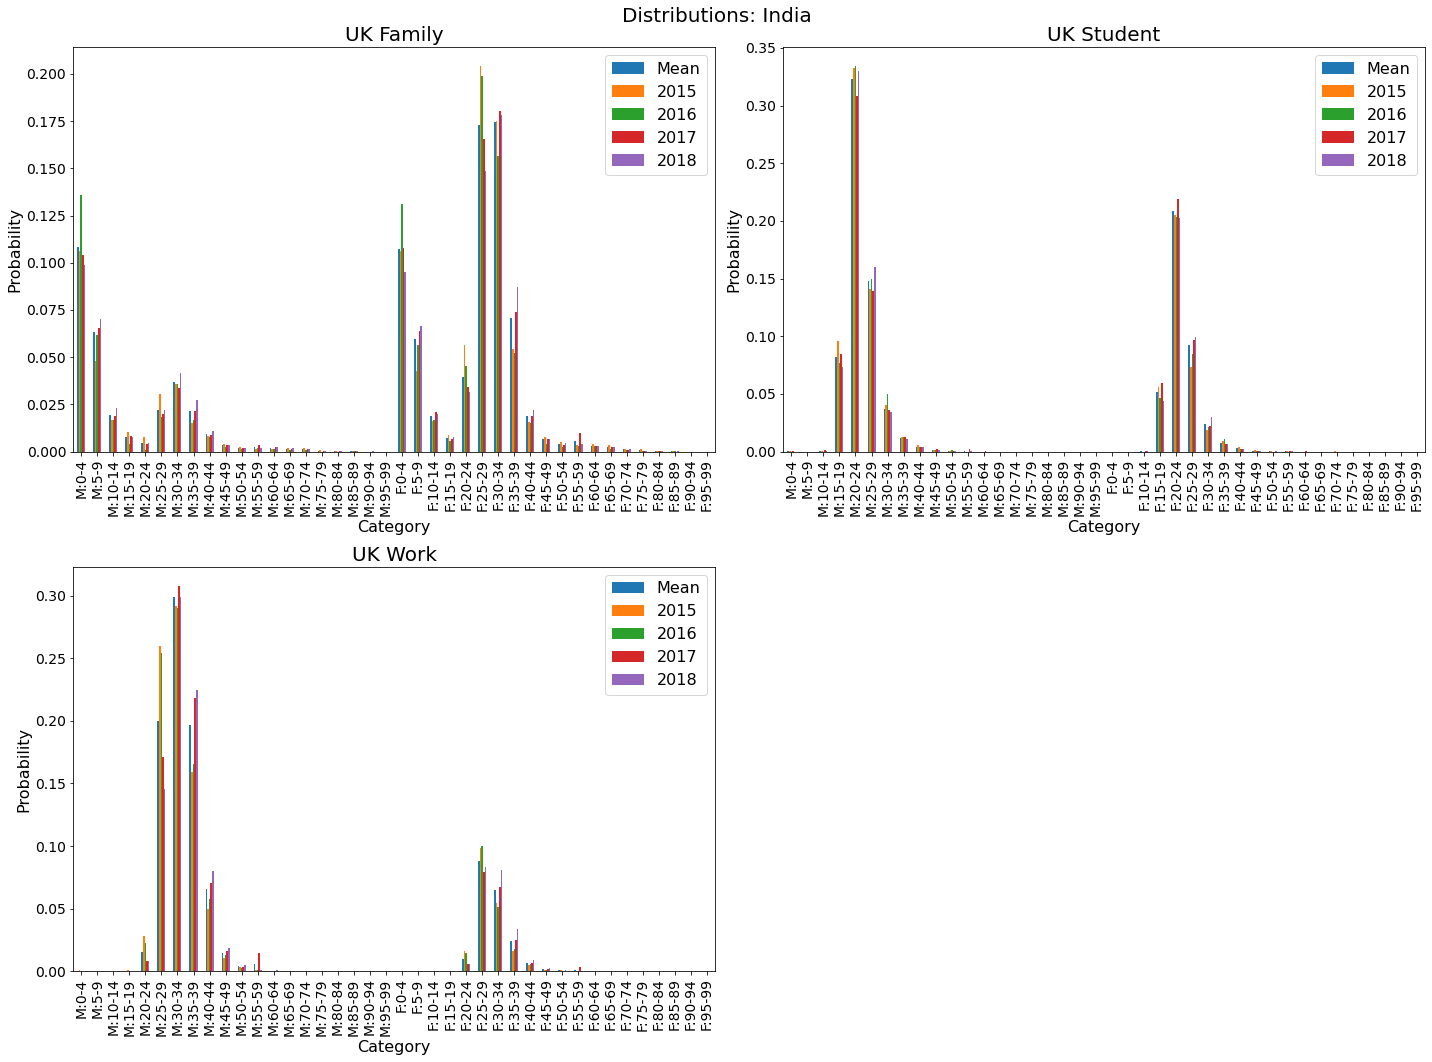

In [17]:
currentRegion = 'India'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(3):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)

# Turn off the last subplot. 
ax[-1, -1].axis('off')

fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

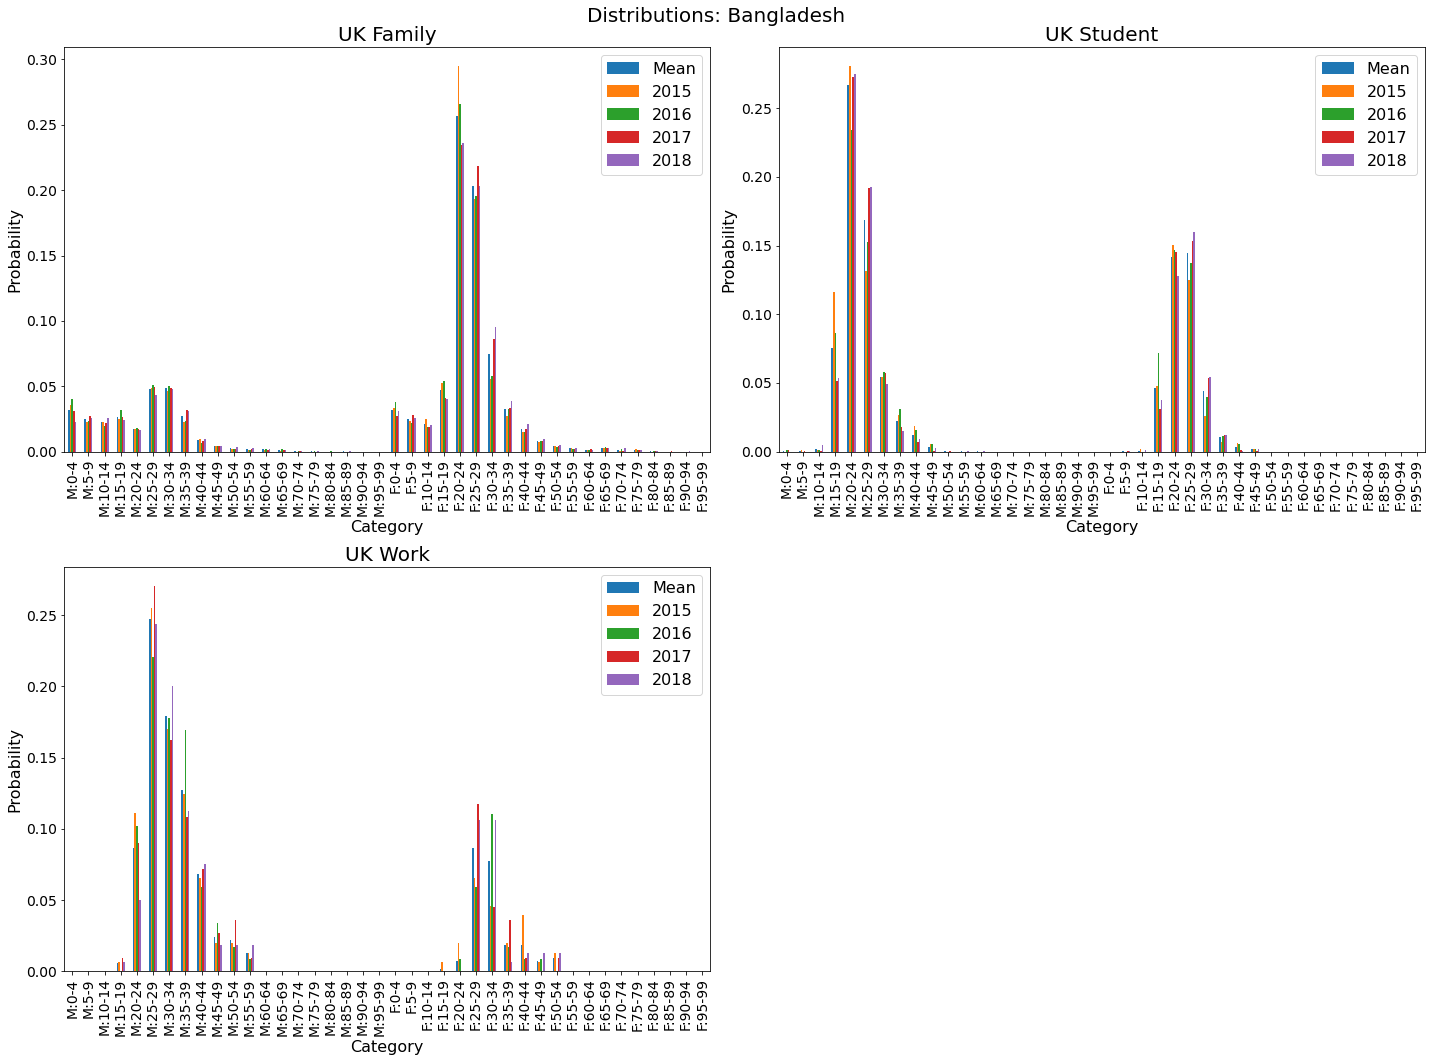

In [18]:
currentRegion = 'Bangladesh'

n_cols = 2
n_rows = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows)

for i in range(3):
    i_row = i // n_cols
    i_col = i % n_cols
    currentVisa = visaSet[i]
    currentAx = ax[i_row, i_col]
    CV = (currentRegion, currentVisa)
    currentMean = MeanAgeSexDistrByCV[CV]

    plot_df = pd.DataFrame({'Labels': names,
                            'Mean': currentMean})

    for y in years:
        currentIndex = CV + (y,)
        plot_df[y] = meanByCVYear[currentIndex]

    plot_df.plot.bar(x='Labels', rot=90, ax=currentAx)
    currentAx.set_title(currentVisa, fontsize=20)
    currentAx.set_ylabel('Probability', fontsize=16)
    currentAx.set_xlabel('Category', fontsize=16)
    currentAx.tick_params(axis='both', which='major', labelsize=14)
    currentAx.legend(fontsize=16)

# Turn off the last subplot. 
ax[-1, -1].axis('off')

fig.set_size_inches(20, 7.5*n_rows)
fig.suptitle(f'Distributions: {currentRegion}', fontsize=20)
fig.tight_layout()
plt.show()

# Discussion

 * Generally, settlement and reunifcation visa distributions are more changeable over time than the student and work visas. China and India seem particularly variable. 
 * The Bangladesh reunification visa distribution is particularly poor with data only from 2017 and that being very poorly populated. I'm not sure what's going on here.  
 * In terms of numbers screened, several things stand out:
     * In India in 2018, there's a sudden increase in adult settlement visas and a drop in the reunification visa. These seem to match up. 
     * Something similar is happening in China at the same time, but the situation is more complicated. 
     * There really are only 3 people on reunification visas from Bangladesh between 2015 and 2018! 
     
In general, aggregating to 3 visa categories seems to stablise the distributions over time and also removes the very poor distribution for Bangladesh Family Reunification.  

## Requirements
The following files are needed by this notebook: 
 - **clean_edetecttb_JET.csv**: data file from Laura, cleaned up. 
 - **requirements.txt**: Needed if using binder to render the notebook. 
 The following should be in the folder, **SharedFiles**:
 - **DefEncoding_4visa.p**: pickled encoding dictionaries for the 4-visa setup.
 - **DefEncoding_3v6c.p**: pickled encoding dictionaries for the 3v5c setup.